# Using Non-linear Transformations

## Doing variable transformations

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

def load_california_housing_data():
    dataset = fetch_california_housing()
    X = pd.DataFrame(data=dataset.data, 
                     columns=dataset.feature_names)
    y = pd.Series(data=dataset.target, name="target")
    print(dataset.DESCR)
    return X, y

X, y = load_california_housing_data()

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [2]:
X["AveOccup"] = X["AveOccup"].clip(upper=100)

X['AveOccupRooms'] = X['AveOccup'] / X['AveRooms']
X['AveOccupBedrms'] = X['AveOccup'] / X['AveBedrms']
X['Rooms_capita'] = X['Population'] / X['AveRooms']
X['Bedrms_capita'] =  X['Population'] / X['AveBedrms']
X['Bedrms_pct'] = X['AveBedrms'] / X['AveRooms']

In [3]:
import numpy as np
from sklearn.feature_selection import f_regression

single_variable = X["AveOccup"].values.reshape(-1, 1)
F, pval = f_regression(single_variable, y)
print(f'F score for the original feature {F[0]:.1f}')

F, pval = f_regression(np.log1p(single_variable),y)
print(f'F score for the transformed feature {F[0]:.1f}')

F score for the original feature 275.8
F score for the transformed feature 1434.7


## Creating interactions between variables

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection  import cross_val_score, KFold

regression = Pipeline([("scaler", StandardScaler()), ("model",LinearRegression())])
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

baseline = np.mean(cross_val_score(regression, X, y, 
                                   scoring='neg_mean_squared_error', 
                                   cv=crossvalidation))

print(f'Baseline MSE: {abs(baseline):.3f}')

Baseline MSE: 0.507


In [5]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures((2, 2), interaction_only=True, include_bias=False)
features = ["MedInc", "HouseAge", "Population", "AveRooms", "AveBedrms", "AveOccup"]
poly.fit(X[features])
interactions = pd.DataFrame(poly.transform(X[features]), columns=poly.get_feature_names_out(features))


In [6]:
print(interactions.shape)

(20640, 15)


In [7]:
for col in interactions:
    Xt = pd.concat([X, interactions[col]], axis=1)
    
    test = np.mean(cross_val_score(regression, Xt, y, 
                                   scoring='neg_mean_squared_error', 
                                   cv=crossvalidation))
    if test > baseline:
        print(f"adding interaction {col} improves MSE to {abs(test):0.3f}")

adding interaction MedInc HouseAge improves MSE to 0.504
adding interaction MedInc Population improves MSE to 0.500
adding interaction MedInc AveRooms improves MSE to 0.501
adding interaction MedInc AveBedrms improves MSE to 0.506
adding interaction MedInc AveOccup improves MSE to 0.507
adding interaction HouseAge Population improves MSE to 0.506
adding interaction Population AveOccup improves MSE to 0.490


# Regularizing linear models

## Relying on ridge regression

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

Xt = pd.concat([X, interactions], axis=1)

ridge = Pipeline([("scaler", StandardScaler()), ("model",Ridge())])
search_grid = {'model__alpha': np.logspace(-6, 4, 20)}
search = GridSearchCV(estimator=ridge, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=crossvalidation)
search.fit(Xt, y)
print(f'Best parameters: {search.best_params_}')
score = abs(search.best_score_)
print(f'CV MSE of best parameters: {score:.3f}')

Best parameters: {'model__alpha': 263.6650898730355}
CV MSE of best parameters: 0.499


## Using the Lasso

In [9]:
from sklearn.linear_model import Lasso
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
 
lasso = Pipeline([("scaler", StandardScaler()), ("model",Lasso(selection='random'))])

search_grid = {'model__alpha': np.logspace(-6, 4, 20)}
search = GridSearchCV(estimator=lasso, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=crossvalidation)
search.fit(Xt, y)
best_alpha = search.best_params_
print(f'Best parameters: {search.best_params_}')
score = abs(search.best_score_)
print(f'CV MSE of best parameters: {score:.3f}')

Best parameters: {'model__alpha': 0.004832930238571752}
CV MSE of best parameters: 0.493


## Leveraging regularization for feature selection

In [10]:
selection = np.abs(
    search.best_estimator_["model"].coef_) > 0
print(Xt.columns[selection].tolist())

['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude', 'AveOccupRooms', 'AveOccupBedrms', 'Rooms_capita', 'Bedrms_capita', 'Bedrms_pct', 'MedInc HouseAge', 'MedInc Population', 'MedInc AveRooms', 'HouseAge Population', 'HouseAge AveOccup', 'Population AveRooms', 'Population AveOccup']


## Combining L1 & L2: Elasticnet

In [11]:
from sklearn.linear_model import ElasticNet

elastic = Pipeline([("scaler", StandardScaler()), ("model", ElasticNet(selection='random'))])
search_grid = {'model__alpha': np.logspace(-6, 4, 20), 
               'model__l1_ratio': [0.05, 0.10 ,0.25, 0.5, 0.75, 0.90, 0.95]}
search = GridSearchCV(estimator=elastic, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=crossvalidation)
search.fit(Xt, y)
print(f'Best parameters: {search.best_params_}')
score = abs(search.best_score_)
print(f'CV MSE of best parameters: {score:.3f}')


Best parameters: {'model__alpha': 0.004832930238571752, 'model__l1_ratio': 0.95}
CV MSE of best parameters: 0.493


# Fighting with Big Data Chunk by Chunk

## Implementing Stochastic Gradient Descent

In [12]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

scaling = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaling.fit_transform(Xt)

X_tr, X_t, y_tr, y_t = train_test_split(scaled_X, y, 
                                        test_size=0.20, 
                                        random_state=0)

SGD = SGDRegressor(loss='squared_error', 
                   penalty='l1', 
                   alpha=0.00001, 
                   max_iter=2000,
                   learning_rate="adaptive",
                   random_state=0)

SGD.fit(X_tr, y_tr)

score = mean_squared_error(y_t, SGD.predict(X_t))
print(f'test MSE: {score:.3f}')

test MSE: 0.494


In [13]:
SGD = SGDRegressor(loss='squared_error', 
                   penalty='l1', 
                   alpha=0.00001,
                   learning_rate="adaptive",
                   random_state=0)

improvements = list()

for z in range(2000):
    SGD.partial_fit(X_tr, y_tr)
    score = mean_squared_error(y_t, SGD.predict(X_t))
    improvements.append(score)
    
print(f'test MSE: {improvements[-1]:.3f}')

test MSE: 0.472


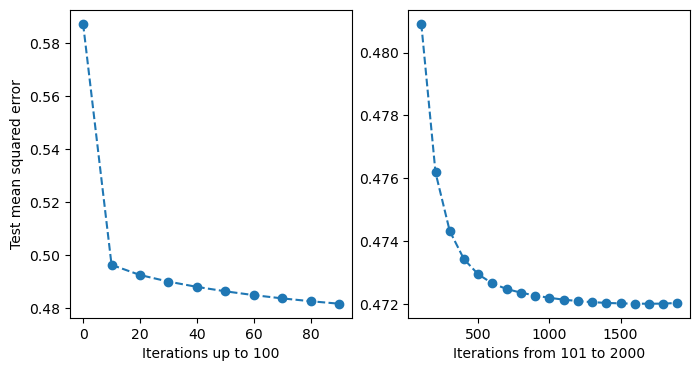

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
range_1 = range(0,100,10)
score_1 = np.abs(improvements[0:100:10])
plt.plot(range_1, score_1,'o--')
plt.xlabel('Iterations up to 100')
plt.ylabel('Test mean squared error')
plt.subplot(1,2,2)
range_2 = range(100,2000,100)
score_2 = np.abs(improvements[100:2000:100])
plt.plot(range_2, score_2,'o--')
plt.xlabel('Iterations from 101 to 2000')
plt.show()

# Understanding Support Vector Machines

## Classifying with SVC

In [15]:
from sklearn import datasets
digits = datasets.load_digits()
X, y = digits.data, digits.target

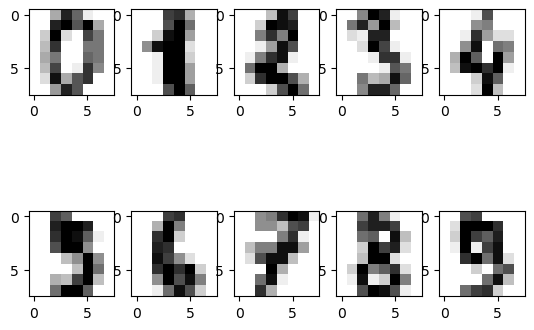

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,img in enumerate(range(10)):
    plt.subplot(2, 5, k+1)
    plt.imshow(digits.images[img], 
               cmap='binary', 
               interpolation='none')
plt.show()

In [17]:
print(X[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [18]:
print(X[0].reshape(8,8))

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [19]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64))

In [20]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
X_tr, X_t, y_tr, y_t = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [21]:
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(X_tr)
X_tr = scaling.transform(X_tr)
X_t = scaling.transform(X_t)

In [22]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', 
          class_weight='balanced')

In [23]:
cv = cross_val_score(svc, X_tr, y_tr, cv=10)
test_score = svc.fit(X_tr, y_tr).score(X_t, y_t)

In [24]:
print(f'CV accuracy score: {np.mean(cv):.3f}')
print(f'Test accuracy score: {test_score:.3f}')

CV accuracy score: 0.981
Test accuracy score: 0.976


In [25]:
from sklearn.model_selection  import GridSearchCV
svc = SVC(class_weight='balanced', random_state=1)
search_space = {'C': np.logspace(-3, 3, 7)}
gridsearch = GridSearchCV(svc, 
                          param_grid=search_space, 
                          scoring='accuracy', 
                          refit=True, cv=10)
gridsearch.fit(X_tr,y_tr)

GridSearchCV(cv=10, estimator=SVC(class_weight='balanced', random_state=1),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='accuracy')

In [26]:
cv = gridsearch.best_score_
test_score = gridsearch.score(X_t, y_t)
best_c =  gridsearch.best_params_['C']

In [27]:
print(f'CV accuracy score: {cv:.3f}')
print(f'Test accuracy score: {test_score:.3f}')
print(f'Best C parameter: {best_c:.1f}')

CV accuracy score: 0.990
Test accuracy score: 0.993
Best C parameter: 10.0


## Going nonlinear is easy

In [28]:
from sklearn.model_selection import GridSearchCV
svc = SVC(class_weight='balanced', random_state=1)
search_space = [{'kernel': ['linear'], 
                 'C': np.logspace(-3, 3, 7)},
                {'kernel': ['rbf'], 
                 'degree':[2, 3, 4], 
                 'C':np.logspace(-3, 3, 7), 
                 'gamma': np.logspace(-3, 2, 6)}]
gridsearch = GridSearchCV(svc, 
                          param_grid=search_space, 
                          scoring='accuracy', 
                          refit=True, cv=10,
                          n_jobs=-1)
gridsearch.fit(X_tr, y_tr)
cv = gridsearch.best_score_
test_score = gridsearch.score(X_t, y_t)
print(f'CV accuracy score: {cv:0.3f}')
print(f'Test accuracy score: {test_score:0.3f}')
print(f'Best parameters: {gridsearch.best_params_}')

CV accuracy score: 0.990
Test accuracy score: 0.993
Best parameters: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


## Performing regression with SVR

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=500, 
                       n_features=15, 
                       n_informative=3, 
                       noise=10,
                       random_state=101)

X_tr, X_t, y_tr, y_t = train_test_split(X, y, 
                                        test_size=0.3, 
                                        random_state=0)
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(X_tr)
X_tr = scaling.transform(X_tr)
X_t  = scaling.transform(X_t)

In [30]:
svr = SVR()
search_space = [{'kernel': ['linear'], 
                 'C': np.logspace(-3, 2, 6), 
                 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]},
                {'kernel': ['rbf'], 
                 'degree':[2,3], 
                 'C':np.logspace(-3, 3, 7), 
                 'gamma': np.logspace(-3, 2, 6), 
                 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]}]
gridsearch = GridSearchCV(svr, 
                          param_grid=search_space, 
                          refit=True, 
                          scoring= 'r2',
                          cv=10, n_jobs=-1)
gridsearch.fit(X_tr, y_tr)
cv = gridsearch.best_score_
test_score = gridsearch.score(X_t, y_t)
print(f'CV R2 score: {cv:.3f}')
print(f'Test R2 score: {test_score:.3f}')
print(f'Best parameters: {gridsearch.best_params_}')

CV R2 score: 0.990
Test R2 score: 0.992
Best parameters: {'C': 100.0, 'epsilon': 0.5, 'kernel': 'linear'}


## Creating a stochastic solution with SVM

In [31]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X,y = make_classification(n_samples=500, 
                          n_features=15, 
                          n_informative=5, 
                          random_state=101)
X_tr, X_t, y_tr, y_t = train_test_split(X, y, 
                                        test_size=0.3, 
                                        random_state=1)

from sklearn.svm import SVC, LinearSVC
svc = SVC(kernel='linear', random_state=0)
linear = LinearSVC(loss='hinge', max_iter=100_000, random_state=0)

svc.fit(X_tr, y_tr)
linear.fit(X_tr, y_tr)
svc_score = svc.score(X_t, y_t)
libsvc_score = linear.score(X_t, y_t)
print(f'SVC test accuracy: {svc_score:.3f}')
print(f'LinearSVC test accuracy: {libsvc_score:.3f}')

SVC test accuracy: 0.787
LinearSVC test accuracy: 0.787


In [33]:
import timeit
import numpy as np

X,y = make_classification(n_samples=10**3, 
                          n_features=15, 
                          n_informative=5, 
                          random_state=101)
t_svc = timeit.timeit(
    'svc.fit(X, y)',
    'from __main__ import svc, X, y',
    number=3)
t_libsvc = timeit.timeit(
    'linear.fit(X, y)',
    'from __main__ import linear, X, y',
    number=3)
print(f'best avg secs for SVC: {np.mean(t_svc):0.1f}')
print(f'best avg secs for LinearSVC: '
      f'{np.mean(t_libsvc):0.1f}')

best avg secs for SVC: 0.2
best avg secs for LinearSVC: 0.1


In [34]:
X,y = make_classification(n_samples=3*10**3, 
                          n_features=15, 
                          n_informative=5, 
                          random_state=101)
t_svc = timeit.timeit('svc.fit(X, y)',
                      'from __main__ import svc, X, y', 
                      number=3)
t_linear = timeit.timeit('linear.fit(X, y)',
                         'from __main__ import linear, X, y', 
                         number=3)
print(f'Avg time for SVC: {np.mean(t_svc):0.1f} secs')
print(f'Avg time for LinearSVC: {np.mean(t_linear):0.1f} secs')

Avg time for SVC: 1.5 secs
Avg time for LinearSVC: 0.1 secs


In [36]:
X,y = make_classification(n_samples=5*10**4, 
                          n_features=15, 
                          n_informative=5, 
                          random_state=101)
t_svc = timeit.timeit('svc.fit(X, y)',
                      'from __main__ import svc, X, y', 
                      number=3)
t_linear = timeit.timeit('linear.fit(X, y)',
                         'from __main__ import linear, X, y', 
                         number=3)
print(f'Avg time for SVC: {np.mean(t_svc):.1f} secs')
print(f'Avg time for LinearSVC: {np.mean(t_linear):.1f} secs')

Avg time for SVC: 901.6 secs
Avg time for LinearSVC: 4.2 secs


In [37]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
import timeit

from sklearn.linear_model import SGDClassifier
X, y = make_classification(n_samples=10**5, 
                           n_features=15, 
                           n_informative=10, 
                           random_state=101)
X_tr, X_t, y_tr, y_t = train_test_split(X, y,
                                        test_size=0.3, 
                                        random_state=1)

In [38]:
linear = LinearSVC(penalty='l2', 
                   loss='hinge', 
                   dual=True,
                   random_state=101)
linear.fit(X_tr, y_tr)
score = linear.score(X_t, y_t)
t = timeit.timeit("linear.fit(X_tr, y_tr)", 
        "from __main__ import linear, X_tr, y_tr", 
        number=1)
print(f'LinearSVC test accuracy: {score:.3f}')
print(f'Avg time for LinearSVC: {np.mean(t):.1f} secs')

LinearSVC test accuracy: 0.796
Avg time for LinearSVC: 3.6 secs


In [39]:
sgd = SGDClassifier(loss='hinge',
                    penalty='l2',
                    alpha=0.1,
                    max_iter=1000, 
                    shuffle=True, 
                    random_state=101)
sgd.fit(X_tr, y_tr)
score = sgd.score(X_t, y_t)
t = timeit.timeit("sgd.fit(X_tr, y_tr)", 
                  "from __main__ import sgd, X_tr, y_tr", 
                  number=1)
print(f'SGDClassifier test accuracy: {score:.3f}')
print(f'Avg time for SGDClassifier: {np.mean(t):.1f} secs')

SGDClassifier test accuracy: 0.796
Avg time for SGDClassifier: 0.1 secs


# Playing with Neural Networks

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_digits
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [2]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
num_classes = 10
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

In [4]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(64,)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
45/45 [==============================] - 3s 10ms/step - loss: 2.0582 - accuracy: 0.2770 - val_loss: 1.5657 - val_accuracy: 0.6139
Epoch 2/50
45/45 [==============================] - 0s 5ms/step - loss: 1.3471 - accuracy: 0.5706 - val_loss: 0.8581 - val_accuracy: 0.8389
Epoch 3/50
45/45 [==============================] - 0s 6ms/step - loss: 0.9317 - accuracy: 0.6924 - val_loss: 0.5482 - val_accuracy: 0.8972
Epoch 4/50
45/45 [==============================] - 0s 6ms/step - loss: 0.6953 - accuracy: 0.7704 - val_loss: 0.4121 - val_accuracy: 0.9111
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 0.5457 - accuracy: 0.8114 - val_loss: 0.3224 - val_accuracy: 0.9361
Epoch 6/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4699 - accuracy: 0.8448 - val_loss: 0.2698 - val_accuracy: 0.9333
Epoch 7/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4037 - accuracy: 0.8789 - val_loss: 0.2392 - val_accuracy: 0.9389
Epoch 8/50
45/45 [=

In [5]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy score:', accuracy)

12/12 [==============================] - 0s 5ms/step - loss: 0.1084 - accuracy: 0.9750
Test accuracy score: 0.9750000238418579


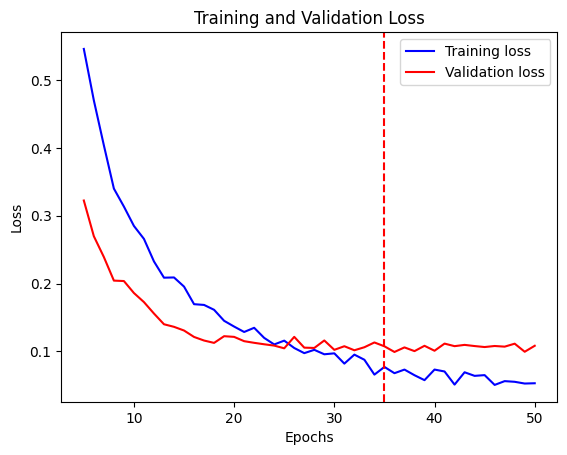

In [7]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss over epochs
epochs = range(5, len(train_loss) + 1)
plt.plot(epochs, train_loss[4:], 'b', 
         label='Training loss')
plt.plot(epochs, val_loss[4:], 'r', 
         label='Validation loss')
plt.axvline(x=val_loss.index(min(val_loss)), 
            color='r', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()